In [1]:
import sys

sys.path.append('../../notebooks')
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from notebooks.core import constants
from notebooks.core import model_utils

In [2]:
df = pd.read_json("../../data/translated/sarcasm/sarcasm_headlines_dataset_pl.json")
df

,is_sarcastic,headline,article_link,headline_pl
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,Jedz warzywa: 9 pysznie różnych przepisów
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...,Żydzi świętują Rosh Hashasha czy coś
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...,Śledczy spraw wewnętrznych rozczarowany spiski...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...,Najpiękniejsza przemowa akceptacyjna w tym tyg...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...,Mars zniszczony przez pałac kosmiczny na orbic...


In [3]:
df = df.drop(columns=['article_link', 'headline'])
df

,is_sarcastic,headline_pl
0,1,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,Jedz warzywa: 9 pysznie różnych przepisów
3,1,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...
28614,1,Żydzi świętują Rosh Hashasha czy coś
28615,1,Śledczy spraw wewnętrznych rozczarowany spiski...
28616,0,Najpiękniejsza przemowa akceptacyjna w tym tyg...
28617,1,Mars zniszczony przez pałac kosmiczny na orbic...


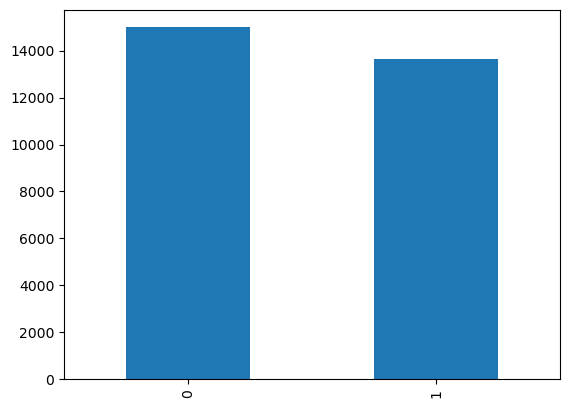

In [4]:
data = df["is_sarcastic"]
data.value_counts().plot.bar()
plt.show()

In [5]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

Dataset({
    features: ['is_sarcastic', 'headline_pl'],
    num_rows: 28619
})

In [6]:
from transformers import AutoTokenizer

MAX_TOKENS = 128
EOS_TOKEN = "<|endoftext|>"
checkpoint = "flax-community/papuGaPT2"

tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    eos_token=EOS_TOKEN,
    pad_token=EOS_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

tokenizer.padding_side = "left"

In [7]:
def tokenize_function(examples):
    examples = [ex + EOS_TOKEN for ex in examples['headline_pl']]

    output = tokenizer(
        examples,
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding=True,
    )

    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output

In [8]:
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/28619 [00:00<?, ? examples/s]

In [9]:
# Train set: 80%, Validation set: 10%, Test set: 10%
tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset = model_utils.split_train_val_test(
    tokenized_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5)

In [10]:
from transformers import DataCollatorWithPadding

columns = ["input_ids", "attention_mask"]
label_cols = ["is_sarcastic"]
batch_size = 16
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = model_utils.convert_to_tf_dataset(tokenized_train_dataset, columns, label_cols, data_collator,
                                                     batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(tokenized_val_dataset, columns, label_cols, data_collator,
                                                   batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(tokenized_test_dataset, columns, label_cols, data_collator,
                                                    batch_size)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [11]:
# Model parameters
training_number = 1
model_name = "sarcasm_pl_gpt2"

training_name = f"training_{training_number}"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
figures_dir = f"../../documentation/models/{model_name}/figures"
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [12]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [13]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [14]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id, use_cache=False, num_labels=2, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFGPT2ForSequenceClassification: ['transformer.h.10.attn.masked_bias', 'transformer.h.1.attn.masked_bias', 'transformer.h.5.attn.masked_bias', 'transformer.h.0.attn.masked_bias', 'lm_head.weight', 'transformer.h.6.attn.masked_bias', 'transformer.h.2.attn.masked_bias', 'transformer.h.4.attn.masked_bias', 'transformer.h.11.attn.masked_bias', 'transformer.h.3.attn.masked_bias', 'transformer.h.9.attn.masked_bias', 'transformer.h.8.attn.masked_bias', 'transformer.h.7.attn.masked_bias']
- This IS expected if you are initializing TFGPT2ForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFGPT2ForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassificat

In [15]:
model.summary()

Model: "tfgp_t2for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
score (Dense)                multiple                  1536      
_________________________________________________________________
transformer (TFGPT2MainLayer multiple                  124439808 
Total params: 124,441,344
Trainable params: 124,441,344
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs,
                    callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
1431/1431 [==============================] - 215s 143ms/step - loss: 0.4729 - accuracy: 0.7686 - val_loss: 0.4359 - val_accuracy: 0.7921

Epoch 00001: saving model to ../../training_checkpoints\sarcasm_pl_gpt2\training_1\cp-0001.ckpt
Epoch 2/10
1431/1431 [==============================] - 203s 142ms/step - loss: 0.2432 - accuracy: 0.8985 - val_loss: 0.4413 - val_accuracy: 0.8183

Epoch 00002: saving model to ../../training_checkpoints\sarcasm_pl_gpt2\training_1\cp-0002.ckpt
Epoch 3/10
1431/1431 [==============================] - 201s 140ms/step - loss: 0.0874 - accuracy: 0.9689 - val_loss: 0.6315 - val_accuracy: 0.8274

Epoch 00003: saving model to ../../training_checkpoints\sarcasm_pl_gpt2\training_1\cp-0003.ckpt
Epoch 4/10
1431/1431 [==============================] - 203s 142ms/step - loss: 0.0328 - accuracy: 0.9887 - val_loss: 0.7347 - val_accuracy: 0.8256

Epoch 00004: saving model to ../../training_checkpoints\sarcasm_pl_gpt2\training_1\cp-0004.ckpt


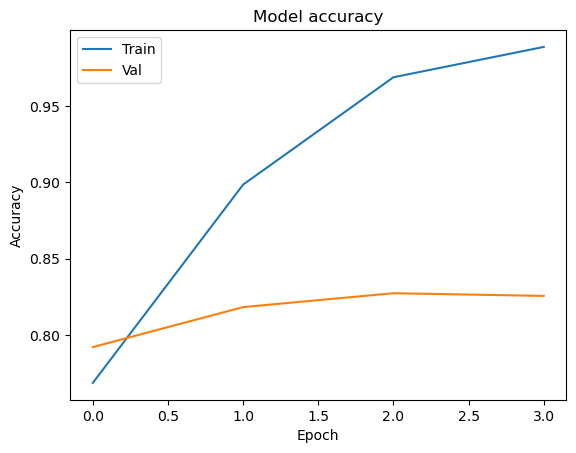

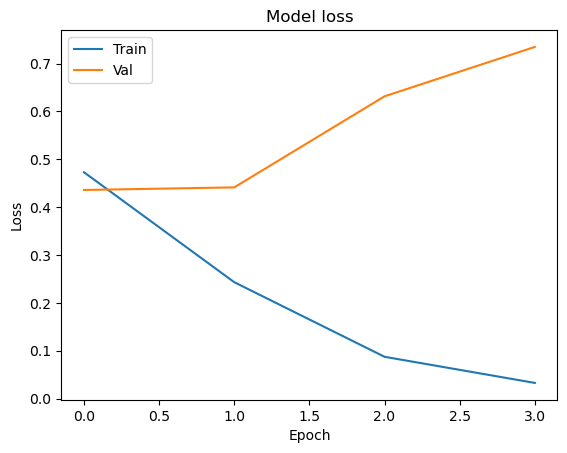

In [18]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [19]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [20]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number, saved_models_dir=constants.SAVED_MODEL_LOCATION, default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ../../trained_models\sarcasm_pl_gpt2_1\1\assets


INFO:tensorflow:Assets written to: ../../trained_models\sarcasm_pl_gpt2_1\1\assets


In [21]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

179/179 [==============================] - 9s 47ms/step - loss: 0.4110 - accuracy: 0.8071


[0.4109562039375305, 0.8071278929710388]

In [22]:
class_preds = model_utils.get_class_preds(model, tf_test_dataset)

In [23]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset['is_sarcastic'],
    class_preds=class_preds,
)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.9125628140703518
Recall score:  0.6613255644573925
F1 score:  0.7668918918918919


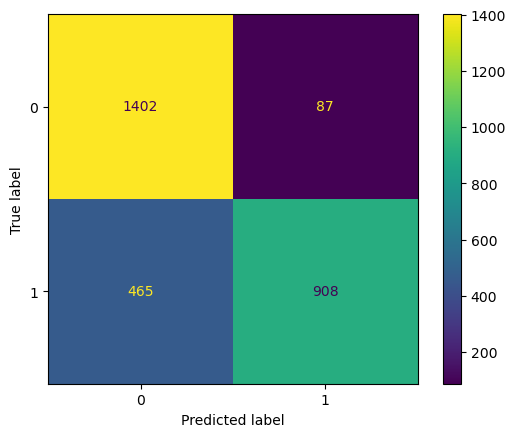

In [24]:
model_utils.plot_and_save_conf_matrix(class_actual=tokenized_test_dataset['is_sarcastic'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [25]:
model_utils.print_incorrectly_predicted_texts(texts=raw_dataset['headline_pl'],
                                              class_actual=raw_dataset['is_sarcastic'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 2
            - TEXT: Jedz warzywa: 9 pysznie różnych przepisów
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 4
            - TEXT: matka jest bardzo blisko użycia słowa "streaming" poprawnie
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 7
            - TEXT: Darowizna Richarda Brandona na ocieplenie świata prawie tyle samo, co koszt nieudanych lotów balonem
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 9
            - TEXT: Wielu rodziców zna ten scenariusz.
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 10
            - TEXT: Ta lesbijka jest uważana za ojca w Indiach (i niesamowita w tym)
            - PREDICTED VALU